#### <b>QF603 project - portfolios construction

In this project --> Analyzing the extent that CAPM / Fama French 3 factor / Cahart 4 factor / Fama French 5 factor can describe stock's return in Nasdaq 100

#### Equation of the models

<table>
  <tr>
    <td><img src="CAPM.png" width="500" height="250"></td>
    <td><img src="FF3.png" width="500" height="250"></td>
  </tr>
  <tr>
    <td><img src="CH4.png" width="500" height="250"></td>
    <td><img src="FF5.png" width="500" height="250"></td>
  </tr>
</table>

#### Import all of data

In [2]:
import pandas as pd
import numpy as np
file_path = 'datarequired.xlsx'
raw_data = pd.ExcelFile(file_path)
sheet_names = raw_data.sheet_names

In [3]:
sp500index = raw_data.parse('1 - S&P500', index_col=[0])
usreturn = raw_data.parse('2 - US treasury return', index_col=[0])
ndx100monthlyprices = raw_data.parse('3 - Nasdaq100return', index_col=[0])
ndx100opincome = raw_data.parse('4 - Nasdaq100operatinginc', index_col=[0])
ndx100intexp = raw_data.parse('5 - Nasdaq100intexp', index_col=[0])
ndx100ttassets = raw_data.parse('6 - Total assets', index_col=[0])
ndx100ttequity = raw_data.parse('7 - Total equity', index_col=[0])
ndx100shareostd = raw_data.parse('8 - Share Outstanding', index_col=[0])
ndx100return = ndx100monthlyprices.pct_change()

#### 1) Create (Rm - Rf)

In [460]:
## Rm - Rf
sp500index['return'] = sp500index['s&p500index'].pct_change()
Rm = sp500index[['return']]
Rf = usreturn
Rm['RmRf'] = Rm['return'] - Rf['ustreasuryintrate']
RmRf = Rm[['RmRf']].loc['2017-07-01':'2022-06-01',]

,RmRf
2017-07-01,0.009509
2017-08-01,-0.008514
2017-09-01,0.009763
2017-10-01,0.012068
2017-11-01,0.016773


(60, 1)

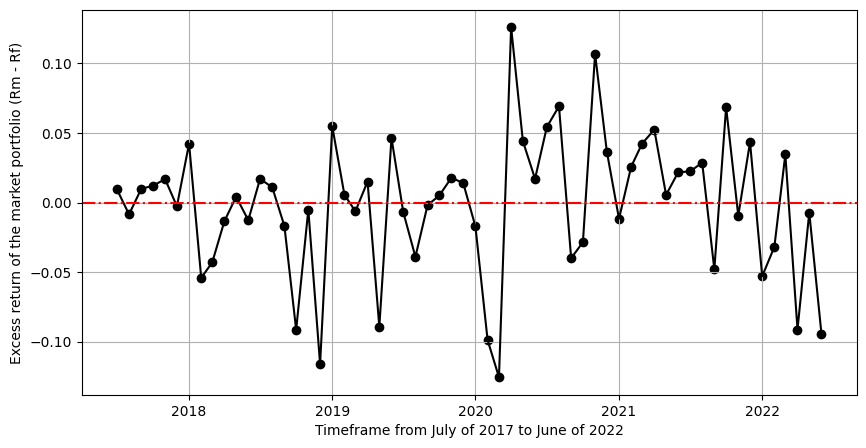

In [461]:
import matplotlib.pyplot as plt
display(RmRf.head())
display(RmRf.shape)
plt.figure(figsize = (10,5))
plt.xlabel("Timeframe from July of 2017 to June of 2022")
plt.ylabel('Excess return of the market portfolio (Rm - Rf)')
plt.plot(RmRf.index, RmRf['RmRf'],color = 'black')
plt.scatter(RmRf.index, RmRf['RmRf'],color = 'black')
plt.axhline(y=0, color='r', linestyle='-.', label='Horizontal Line')
plt.grid()
plt.show()

#### 2.) Create SMB and HML factor

<table>
  <tr>
    <td><img src="SMB.png" width="500" height="80"></td>
    <td><img src="HML.png" width="500" height="80"></td>
  </tr>
</table>

In [462]:
#1 Create dataframe that show the marketcap of all companies in June each year.
#To consider 'Big' and 'Small' Companies, we use market cap of the stock in June of each year.
#For instance, to construct portfolios used from July2017 - June2018, we use market cap that calculate from share outstanding in FQ2/2017 * price at end of 06/2017
clist = list(ndx100monthlyprices.columns)
years = ['2017','2018','2019','2020','2021','2022']
marketcapinJune = {}
for ticker in clist:
        marketcapinJune[ticker] = {}
        for year in years:
            marketcapinJune[ticker]['June' + year ] =\
            (ndx100shareostd.loc['FQ2 '+ year, ticker]*1e6)\
                  * ndx100monthlyprices.loc[year +'-06-01',ticker]
marketcapinJunedf = pd.DataFrame(marketcapinJune).T
marketcapinJunedf.head()

,June2017,June2018,June2019,June2020,June2021,June2022
AAPL,7.045918e+11,8.733110e+11,8.835256e+11,1.546592e+12,2.255839e+12,2.199780e+12
ADBE,6.997009e+10,1.195644e+11,1.432803e+11,2.089488e+11,2.793503e+11,1.724143e+11
ADI,2.515519e+10,3.202661e+10,3.854139e+10,4.259366e+10,6.094899e+10,7.418162e+10
ADP,4.015286e+10,5.298821e+10,6.539163e+10,5.956314e+10,8.013251e+10,8.478799e+10
ADSK,2.237196e+10,2.873493e+10,3.577284e+10,5.243045e+10,6.410124e+10,3.731532e+10


In [463]:
#2 Determine small and big stocks each year by dividing them in to 2 groups according to median of market cap
smallandbig = pd.DataFrame({})
years = ['2017','2018','2019','2020','2021']
for year in years:
    temp = marketcapinJunedf['June' + year].sort_values(ascending = False)
    temp = temp.apply(lambda x :'s' if x < np.median(temp) else 'b')
    smallandbig['June' + year] = temp

smallandbig.head()

,June2017,June2018,June2019,June2020,June2021
AAPL,b,b,b,b,b
MSFT,b,b,b,b,b
AMZN,b,b,b,b,b
META,b,b,b,b,b
CMCSA,b,b,b,b,b


In [464]:
# 3Calculate Bookvalue / Market cap
#for portfolio to be used from July 2017 to June 2018 the book value / market cap = book value FY 2016 / Marketcap at June 2017
# *** Book value = total equity ***
bookvalbymarketcap = {}
clist = list(ndx100ttequity.columns)
years = [2017,2018,2019,2020,2021,2022]
for ticker in clist:
    bookvalbymarketcap[ticker] = {}
    for year in years:
        bookvalbymarketcap[ticker]['June'+str(year)] =\
        (ndx100ttequity.loc['FY '+str(year-1), ticker]*1e6)\
              / marketcapinJunedf.loc[ticker, 'June'+str(year)] 
bookvalbymarketcapdf = pd.DataFrame(bookvalbymarketcap)
bookvalbymarketcapdf

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SNPS,TEAM,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WDAY,XEL
June2017,0.182019,0.106114,0.205350,0.111613,0.072394,0.632065,0.082541,0.175165,0.035199,0.284522,...,0.291104,0.094449,0.361405,0.099564,0.161577,0.098536,0.041691,0.454249,0.063528,0.571593
June2018,0.153493,0.070756,0.317284,0.075054,0.025530,0.642232,0.042014,0.214312,0.040779,0.246949,...,0.257235,0.062148,0.445652,1.444871,0.111089,0.112042,0.047142,0.588824,0.050673,0.577048
June2019,0.121272,0.065341,0.292366,0.072424,-0.007156,0.510043,0.057317,0.169205,0.038385,0.128139,...,0.180560,0.028760,0.390187,2.366081,0.093869,0.088827,0.094229,0.647843,0.034166,0.452665
June2020,0.058508,0.050395,0.274904,0.090658,-0.004022,0.568403,0.062263,0.152643,0.045771,0.077390,...,0.138950,0.012704,0.223398,0.605692,0.083538,0.083583,0.080582,0.757684,0.044874,0.445717
June2021,0.028964,0.047482,0.196852,0.071784,-0.002170,0.533336,0.067041,0.082533,0.051230,0.072929,...,0.116759,0.008900,0.361543,0.106440,0.055035,0.096925,0.166270,0.519007,0.042731,0.442127
June2022,0.028680,0.085822,0.512156,0.066874,0.025874,0.482754,0.196096,0.155178,0.060818,0.053626,...,0.114072,0.006173,0.409579,0.135157,0.097805,0.102629,0.139995,0.790326,0.093284,0.422392


In [465]:
## 4Determine portfolio
def highneutrallow(x):
    x.sort_values(ascending = False)
    percentile30 = np.percentile(x,30)
    percentile70 = np.percentile(x,70)
    percentile100 = np.percentile(x,100)
    ans = x.apply(lambda x: 'l' if x < percentile30\
                  else('n' if x > percentile30 and x < percentile70 \
                  else('h')))
    return ans

highandlowticker = {}
for year in list(smallandbig.columns):
    highandlowticker[year] = {}
    smallticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 's'][[year]].index})
    bigticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 'b'][[year]].index})
    smallticker['bookval/marketcap'] = smallticker['ticker'].apply(lambda x : bookvalbymarketcapdf.loc[year,x])
    smallticker['high/neutral/low'] = highneutrallow(smallticker['bookval/marketcap'])
    bigticker['bookval/marketcap'] = bigticker['ticker'].apply(lambda x : bookvalbymarketcapdf.loc[year,x])
    bigticker['high/neutral/low'] = highneutrallow(bigticker['bookval/marketcap'])
    highandlowticker[year]['s/h'] = list(smallticker[smallticker['high/neutral/low'] == 'h']['ticker'].values)
    highandlowticker[year]['s/n'] = list(smallticker[smallticker['high/neutral/low'] == 'n']['ticker'].values)
    highandlowticker[year]['s/l'] = list(smallticker[smallticker['high/neutral/low'] == 'l']['ticker'].values)
    highandlowticker[year]['b/h'] = list(bigticker[bigticker['high/neutral/low'] == 'h']['ticker'].values)
    highandlowticker[year]['b/n'] = list(bigticker[bigticker['high/neutral/low'] == 'n']['ticker'].values)
    highandlowticker[year]['b/l'] = list(bigticker[bigticker['high/neutral/low'] == 'l']['ticker'].values)

# 5Create return dataframe of each
highandlowreturn = {}
for year,portfolios in highandlowticker.items():
    highandlowreturn[year] = {}
    start_period = str(year[-4:])+'-07-01'
    end_period = str(int(year[-4:]) + 1) + '-06-01'
    for portfolio, stocks in portfolios.items():
        temp = ndx100return[stocks].loc[start_period:end_period]
        temp['average'] = temp.mean(axis = 1)
        highandlowreturn[year][portfolio] = temp['average']

,s/h,s/n,s/l,b/h,b/n,b/l,SMB,HML
2017-07-01,-0.006823,0.037507,0.048004,0.034853,0.033627,0.060844,-0.016879,-0.040409
2017-08-01,0.057953,0.033564,0.008137,0.001316,0.031167,0.006898,0.020091,0.022118
2017-09-01,0.029443,0.035627,0.040432,0.004211,0.042996,-0.021260,0.026519,0.007241
2017-10-01,0.045635,0.076413,0.034361,0.009909,0.033822,0.038018,0.024887,-0.008418
2017-11-01,0.046111,0.051473,0.096173,0.044712,0.015060,-0.015718,0.049901,0.005184


(60, 8)

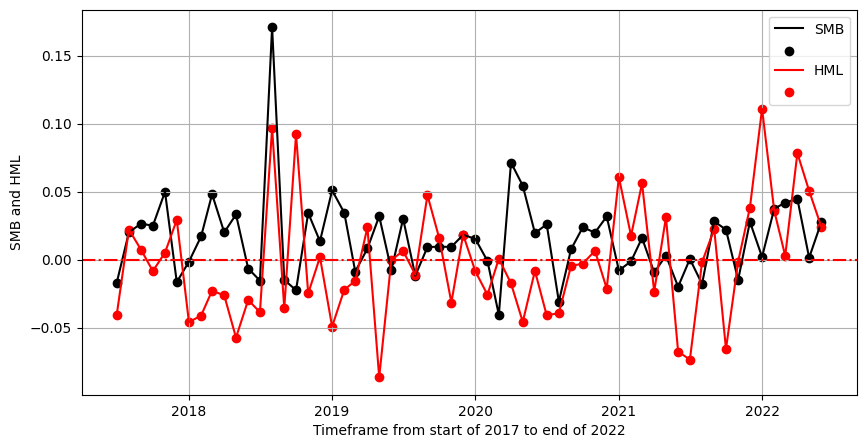

In [484]:
# 6Create dataframe for SMB and HML
SMBHML = pd.DataFrame(highandlowreturn['June2017'])
years = ['June2018','June2019','June2020','June2021']
for year in years:
    SMBHML = pd.concat([SMBHML,pd.DataFrame(highandlowreturn[year])], axis = 0)

SMBHML['SMB'] = ((SMBHML['s/l']+SMBHML['s/n']+SMBHML['s/h'])/3)\
      - ((SMBHML['b/l']+SMBHML['b/n']+SMBHML['b/h'])/3)
SMBHML['HML'] = ((SMBHML['s/h']+SMBHML['b/h'])/2) - ((SMBHML['s/l']+SMBHML['b/l'])/2)

display(SMBHML.head())
display(SMBHML.shape)
plt.figure(figsize = (10,5))
plt.xlabel("Timeframe from start of 2017 to end of 2022")
plt.ylabel('SMB and HML')
plt.plot(SMBHML.index, SMBHML['SMB'],color = 'black')
plt.scatter(SMBHML.index, SMBHML['SMB'],color = 'black')
plt.plot(SMBHML.index, SMBHML['HML'],color = 'red')
plt.scatter(SMBHML.index, SMBHML['HML'],color = 'red')
plt.axhline(y=0, color='r', linestyle='-.', label='Horizontal Line')
plt.grid()
plt.legend(['SMB','','HML',''])
plt.show()


#### 3.) Create MOM factor (Momentum factor)

<table>
  <tr>
    <td><img src="MOM.png" width="400" height="80"></td>
  </tr>
</table>

In [474]:
#1.) Create dataframe that show average return in June each year
#Where average return of year n can be computed form average(return in Jul(n-1), return in Jun(n))
average_return = {}
tickers = list(ndx100return.columns)
years = ['June2017','June2018','June2019','June2020','June2021']
for ticker in tickers:
    average_return[ticker] = {}
    for year in years:
        s_year = year[-4:]
        average_return[ticker][year] =\
        ndx100return[ticker].loc[s_year+'-07-01':str(int(s_year)+1)+'-06-01'].mean()

average_returndf = pd.DataFrame(average_return)   
average_returndf

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SNPS,TEAM,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WDAY,XEL
June2017,0.024141,0.048397,0.020429,0.026948,0.024230,0.003633,0.078587,0.012999,0.025624,0.008973,...,0.014695,0.054862,-0.000147,0.002036,0.033497,0.021436,0.025722,-0.018164,0.020923,0.003270
June2018,0.012682,0.018120,0.020863,0.020871,0.024642,0.023388,-0.003239,0.006496,0.083553,0.004180,...,0.037666,0.069378,0.019396,-0.025315,0.008873,0.027563,0.009344,-0.000030,0.050001,0.025576
June2019,0.056503,0.035218,0.013063,-0.005401,0.038937,-0.003499,0.015885,0.030553,0.050179,0.026515,...,0.038366,0.031448,0.030621,0.160442,0.013931,0.015560,0.041811,-0.015920,0.000217,0.007720
June2020,0.039670,0.027878,0.031711,0.028272,0.019008,0.010366,0.072384,0.080875,0.060796,0.007177,...,0.030734,0.032899,0.030282,0.127750,0.038588,0.005672,-0.026615,0.026055,0.025413,0.008742
June2021,0.002662,-0.033807,-0.010464,0.009207,-0.036889,0.015000,-0.066443,-0.031406,-0.001601,0.004492,...,0.013041,-0.014065,-0.003747,0.011964,-0.015079,0.004496,0.030911,-0.020540,-0.037202,0.009419


,s/lo,s/wi,b/lo,b/wi,MOM
2017-07-01,0.007443,0.029239,0.060844,0.034853,-0.002098
2017-08-01,0.050110,0.051539,0.006898,0.001316,-0.002077
2017-09-01,0.034006,0.047025,-0.021260,0.004211,0.019245
2017-10-01,0.028294,0.103840,0.038018,0.009909,0.023718
2017-11-01,0.027345,0.137953,-0.015718,0.044712,0.085519


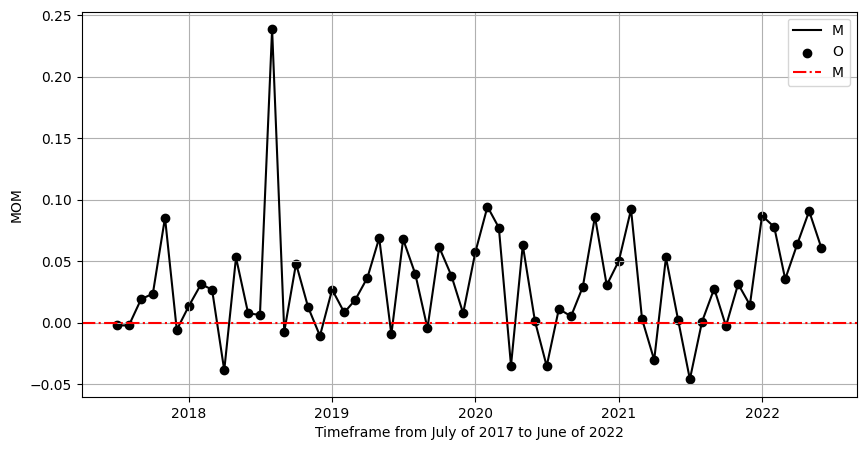

In [485]:
#2.) Determine tickers in portfolio
def loserandwinner(x):
    x.sort_values(ascending = False)
    percentile30 = np.percentile(x,30)
    percentile70 = np.percentile(x,70)
    ans = x.apply(lambda x: 'lo' if x < percentile30\
                  else('wi' if x > percentile70\
                  else('0')))
    return ans

momentum_ticker = {}
years = ['June2017','June2018','June2019','June2020','June2021']
for year in years:
    momentum_ticker[year] = {}
    smallticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 's'][[year]].index})
    bigticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 'b'][[year]].index})
    smallticker['average_return'] = smallticker['ticker'].apply(lambda x : average_returndf.loc[year,x])
    smallticker['loser/winner/none'] = loserandwinner(smallticker['average_return'])
    bigticker['average_return'] = bigticker['ticker'].apply(lambda x : bookvalbymarketcapdf.loc[year,x])
    bigticker['loser/winner/none'] = loserandwinner(bigticker['average_return'])
    momentum_ticker[year]['s/lo'] = list(smallticker[smallticker['loser/winner/none'] == 'lo']['ticker'].values)
    momentum_ticker[year]['s/wi'] = list(smallticker[smallticker['loser/winner/none'] == 'wi']['ticker'].values)
    momentum_ticker[year]['b/lo'] = list(bigticker[bigticker['loser/winner/none'] == 'lo']['ticker'].values)
    momentum_ticker[year]['b/wi'] = list(bigticker[bigticker['loser/winner/none'] == 'wi']['ticker'].values)

#3.) Create return for MOM each year
momentum_return = {}
for year, portfolios in momentum_ticker.items():
    momentum_return[year] = {}
    start_period = str(year[-4:])+'-07-01'
    end_period = str(int(year[-4:]) + 1) + '-06-01'
    for portfolio,stocks in portfolios.items():
        temp = ndx100return[stocks].loc[start_period:end_period]
        temp['average'] = temp.mean(axis = 1)
        momentum_return[year][portfolio] = temp['average']

#4.) Create return dataframe for MOM
MOM = pd.DataFrame(momentum_return['June2017'])
for year in years[1:]:
    MOM = pd.concat([MOM, pd.DataFrame(momentum_return[year])], axis = 0)

#5.) Calculate MOM
MOM['MOM'] = ((MOM['s/wi']+MOM['b/wi'])/2) - ((MOM['s/lo']+MOM['b/lo'])/2)
display(MOM.head())

#6.) Visualize MOM
plt.figure(figsize = (10,5))
plt.xlabel("Timeframe from July of 2017 to June of 2022")
plt.ylabel('MOM')
plt.plot(MOM.index, MOM['MOM'],color = 'black')
plt.scatter(MOM.index, MOM['MOM'],color = 'black')
plt.axhline(y=0, color='r', linestyle='-.', label='Horizontal Line')
plt.grid()
plt.legend('MOM')
plt.show()

#### 4.) Create RMW factor (Operational profit factor)

<table>
  <tr>
    <td><img src="RMW.png" width="500" height="80"></td>
    <td><img src="SMBop.png" width="500" height="80"></td>
  </tr>
</table>

,s/w,s/m,s/r,b/w,b/m,b/r,RMW,SMBop
2017-07-01,0.001259,0.046429,0.027567,0.061021,0.039086,0.027118,-0.003797,-0.017323
2017-08-01,0.041109,0.054793,-0.004414,0.012839,0.010069,0.024588,-0.016887,0.014664
2017-09-01,0.035808,0.023712,0.050564,0.000480,0.024333,0.008312,0.011294,0.025653
2017-10-01,0.039733,0.092639,0.017797,0.034505,0.030409,0.018148,-0.019147,0.022369
2017-11-01,0.082501,0.027576,0.092872,-0.002596,0.029643,0.011400,0.012184,0.054834


(60, 8)

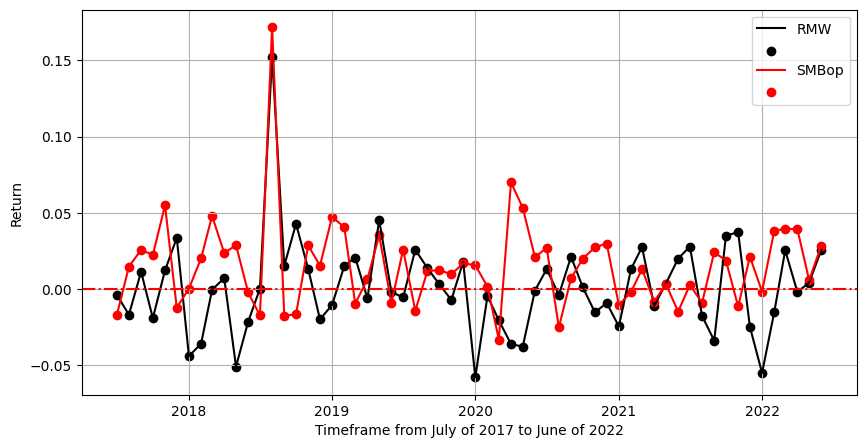

In [486]:
#1.) Create dataframe that shows operation profit of all stock
#for RMW calculation, First the stock shall be divided into 3 Groups according to their operational profitablility
#Due to scarce of interest expense data, the operating profitability is calculated by operating income / book equity
#like other factors, the portfolios for July of year n to June of year n+1 are constructed  in by data in June of year n
#For this factor, the portfolios to be used during July 2017 to June 2018 are constructed by Operating income at the end of FY2016 / Book equity at the end of 2016
ndx100operatingprof = ndx100opincome / ndx100ttequity

#2.) Determine portfolio
def weakneutralrobust(x):
    x.sort_values(ascending = False)
    percentile30 = np.percentile(x,30)
    percentile70 = np.percentile(x,70)
    percentile100 = np.percentile(x,100)
    ans = x.apply(lambda x: 'w' if x < percentile30\
                  else('m' if x > percentile30 and x < percentile70 \
                  else('r')))
    return ans

robustweakticker = {}
years = ['June2017','June2018','June2019','June2020','June2021']
for year in years:
    robustweakticker[year] = {}
    smallticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 's'][[year]].index})
    bigticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 'b'][[year]].index})
    smallticker['operating_profit'] = smallticker['ticker'].apply(lambda x : ndx100operatingprof.loc['FY ' + str(int(year[-4:]) -1),x])
    smallticker['robust/medium/weak'] = weakneutralrobust(smallticker['operating_profit'])
    bigticker['operating_profit'] = bigticker['ticker'].apply(lambda x : ndx100operatingprof.loc['FY ' + str(int(year[-4:]) -1),x])
    bigticker['robust/medium/weak'] = weakneutralrobust(bigticker['operating_profit'])
    robustweakticker[year]['s/w'] = list(smallticker[smallticker['robust/medium/weak'] == 'w']['ticker'].values)
    robustweakticker[year]['s/m'] = list(smallticker[smallticker['robust/medium/weak'] == 'm']['ticker'].values)
    robustweakticker[year]['s/r'] = list(smallticker[smallticker['robust/medium/weak'] == 'r']['ticker'].values)
    robustweakticker[year]['b/w'] = list(bigticker[bigticker['robust/medium/weak'] == 'w']['ticker'].values)
    robustweakticker[year]['b/m'] = list(bigticker[bigticker['robust/medium/weak'] == 'm']['ticker'].values)
    robustweakticker[year]['b/r'] = list(bigticker[bigticker['robust/medium/weak'] == 'r']['ticker'].values)

#3.) Create return
robustweak_return = {}
for year, portfolios in robustweakticker.items():
    robustweak_return[year] = {}
    start_period = str(year[-4:])+'-07-01'
    end_period = str(int(year[-4:]) + 1) + '-06-01'
    for portfolio,stocks in portfolios.items():
        temp = ndx100return[stocks].loc[start_period:end_period]
        temp['average'] = temp.mean(axis = 1)
        robustweak_return[year][portfolio] = temp['average']

#4.) Create return dataframe for RMW
RMW = pd.DataFrame(robustweak_return['June2017'])
years = ['June2018','June2019','June2020','June2021']
for year in years:
    RMW = pd.concat([RMW, pd.DataFrame(robustweak_return[year])], axis = 0)

#5.) Compute RMW and SMPop
RMW['RMW'] = ((RMW['s/r']+RMW['b/r'])/2) - ((RMW['s/w']+RMW['b/w'])/2)
RMW['SMBop'] = ((RMW['s/w'] + RMW['s/m'] + RMW['s/r'])/3) - ((RMW['b/w'] + RMW['b/m'] + RMW['b/r'])/3)
display(RMW.head())
display(RMW.shape)

#6.) Visualize it
plt.figure(figsize = (10,5))
plt.xlabel("Timeframe from July of 2017 to June of 2022")
plt.ylabel('Return')
plt.plot(RMW.index, RMW['RMW'],color = 'black')
plt.scatter(RMW.index, RMW['RMW'],color = 'black')
plt.plot(RMW.index, RMW['SMBop'],color = 'red')
plt.scatter(RMW.index, RMW['SMBop'],color = 'red')
plt.axhline(y=0, color='r', linestyle='-.', label='Horizontal Line')
plt.grid()
plt.legend(['RMW', '','SMBop',''])
plt.show()

#### 5.) Create CMA factor

<table>
  <tr>
    <td><img src="CMA.png" width="500" height="80"></td>
    <td><img src="SMBinv.png" width="500" height="80"></td>
  </tr>
</table>

,s/c,s/n,s/a,b/c,b/n,b/a,CMA,SMBinv
2017-07-01,0.007202,0.029355,0.045265,0.001347,0.041722,0.083143,-0.059930,-0.014796
2017-08-01,0.035248,0.029352,0.036674,-0.001838,0.033888,0.006284,-0.004774,0.020980
2017-09-01,0.084872,0.019591,0.007206,0.029250,0.015143,-0.007734,0.057325,0.025004
2017-10-01,0.023522,0.047504,0.096502,0.000773,0.049217,0.025837,-0.049022,0.030567
2017-11-01,0.128518,0.028132,0.046084,0.056122,0.004647,-0.012709,0.075632,0.051558


(60, 8)

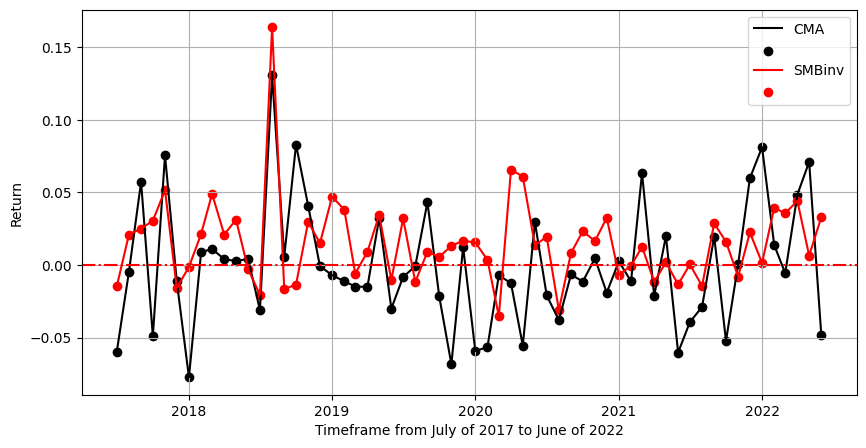

In [487]:
#1.) Create dataframe that shows growth of asset
#for CMA calculation, First the stock shall be divided into 3 groups according to their
#growth in total assets.
#For example, in order to construct portfolio in June2017, we need to compute growth
#by formula : (Total asset in 2016 - Total asset in 2015) / Total asset in 2015
ndx100ttassetsgrowth = {}
years = ['2017','2018','2019','2020','2021']
for ticker in list(ndx100ttequity.columns):
    ndx100ttassetsgrowth[ticker] = {} 
    for year in years:
        ndx100ttassetsgrowth[ticker]['June'+year] =\
        ((ndx100ttassets.loc['FY '+ str(int(year)-1), ticker ])
         - (ndx100ttassets.loc['FY '+ str(int(year)-2), ticker ]))\
         /  ndx100ttassets.loc['FY '+ str(int(year)-2), ticker ]

ndx100ttassetsgrowthdf = pd.DataFrame(ndx100ttassetsgrowth)

#2.)Specifying portfolios
def consandagres(x):
    x.sort_values(ascending = False)
    percentile30 = np.percentile(x,30)
    percentile70 = np.percentile(x,70)
    percentile100 = np.percentile(x,100)
    ans = x.apply(lambda x: 'c' if x < percentile30\
                  else('n' if x > percentile30 and x < percentile70 \
                  else('a')))
    return ans

consandagres_ticker = {}
for year in list(ndx100ttassetsgrowthdf.index):
    consandagres_ticker[year] = {}
    smallticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 's'][[year]].index})
    bigticker = pd.DataFrame({'ticker' :smallandbig[smallandbig[year] == 'b'][[year]].index})
    smallticker['assetgrowth'] = smallticker['ticker'].apply(lambda x : ndx100ttassetsgrowthdf.loc[year,x])
    smallticker['cons/med/aggres'] = consandagres(smallticker['assetgrowth'])
    bigticker['assetgrowth'] = bigticker['ticker'].apply(lambda x : ndx100ttassetsgrowthdf.loc[year,x])
    bigticker['cons/med/aggres'] = consandagres(bigticker['assetgrowth'])
    consandagres_ticker[year]['s/c'] = list(smallticker[smallticker['cons/med/aggres'] == 'c']['ticker'].values)
    consandagres_ticker[year]['s/n'] = list(smallticker[smallticker['cons/med/aggres'] == 'n']['ticker'].values)
    consandagres_ticker[year]['s/a'] = list(smallticker[smallticker['cons/med/aggres'] == 'a']['ticker'].values)
    consandagres_ticker[year]['b/c'] = list(bigticker[bigticker['cons/med/aggres'] == 'c']['ticker'].values)
    consandagres_ticker[year]['b/n'] = list(bigticker[bigticker['cons/med/aggres'] == 'n']['ticker'].values)
    consandagres_ticker[year]['b/a'] = list(bigticker[bigticker['cons/med/aggres'] == 'a']['ticker'].values)

#3.)Specifying return
consandagres_return = {}
for year, portfolios in consandagres_ticker.items():
    consandagres_return[year] = {}
    start_period = str(year[-4:])+'-07-01'
    end_period = str(int(year[-4:]) + 1) + '-06-01'
    for portfolio,stocks in portfolios.items():
        temp = ndx100return[stocks].loc[start_period:end_period]
        temp['average'] = temp.mean(axis = 1)
        consandagres_return[year][portfolio] = temp['average']

#4.)Create return dataframe for CMA
CMA = pd.DataFrame(consandagres_return['June2017'])
for year in list(ndx100ttassetsgrowthdf.index)[1:]:
    CMA = pd.concat([CMA, pd.DataFrame(consandagres_return[year])], axis = 0)
CMA['CMA']= ((CMA['s/c'] + CMA['b/c'])/2) - ((CMA['s/a']+CMA['b/a'])/2)
CMA['SMBinv'] = ((CMA['s/a'] + CMA['s/n'] + CMA['s/c'])/3) - ((CMA['b/a'] + CMA['b/n'] + CMA['b/c'])/3)
display(CMA.head())
display(CMA.shape)

#5.) Visualize it
plt.figure(figsize = (10,5))
plt.xlabel("Timeframe from July of 2017 to June of 2022")
plt.ylabel('Return')
plt.plot(CMA.index, CMA['CMA'],color = 'black')
plt.scatter(CMA.index, CMA['CMA'],color = 'black')
plt.plot(CMA.index, CMA['SMBinv'],color = 'red')
plt.scatter(CMA.index, CMA['SMBinv'],color = 'red')
plt.axhline(y=0, color='r', linestyle='-.', label='Horizontal Line')
plt.grid()
plt.legend(['CMA', '','SMBinv',''])
plt.show()

#### 6.) Create Final Dataframe

<table>
  <tr>
    <td><img src="SMBff5.png" width="500" height="80"></td>
  </tr>
</table>

In [488]:
Output = pd.DataFrame({})
Output['Rm'] = sp500index['return'].loc['2017-07-01':'2022-06-01',]
Output['Rf'] = usreturn['ustreasuryintrate'].loc['2017-07-01':'2022-06-01',]
Output['Rm - Rf'] = RmRf['RmRf']
Output = pd.concat([Output,SMBHML,MOM,RMW,CMA], axis = 1)
Output['SMBff5'] = ((Output['SMB']+Output['SMBop']+Output['SMBinv'])/3)


In [489]:
Output.to_csv('DATATOMODEL_VER1.csv')